In [30]:
import pandas as pd
import numpy as np
import seaborn as sns

In [31]:
df = pd.read_csv("Mutual Funds.csv", dtype={'fund_treynor_ratio_3years': object, 'fund_treynor_ratio_10years': object})

### Drop Funds with Missing Values and Unnecessary Columns 

In [32]:
df.dropna(inplace=True, axis=0, subset=[f"fund_return_{year}" for year in range(2010, 2020)])
df.dropna(inplace=True, axis=0, subset=[f"fund_return_2020_q{i}" for i in range(1, 4)])
df.dropna(inplace=True, axis=0, subset=["size_type"])

In [33]:
# a list of unnecessary columns to drop

list_cols_to_drop = [
 'fund_extended_name',
 'investment_type',
 'investment_strategy',
 'size_type',
 'currency',
 'top10_holdings',
 'bond_maturity',
 'bond_duration',
 'credit_us_government',
 'credit_aaa',
 'credit_aa',
 'credit_a',
 'credit_bbb',
 'credit_bb',
 'credit_b',
 'credit_below_b',
 'credit_other_ratings',
 'fund_yield',
 'quarters_up',
 'quarters_down',
 'fund_alpha_3years',
 'category_alpha_3years',
 'fund_alpha_5years',
 'category_alpha_5years',
 'fund_alpha_10years',
 'category_alpha_10years',
 'fund_beta_3years',
 'category_beta_3years',
 'fund_beta_5years',
 'category_beta_5years',
 'fund_beta_10years',
 'category_beta_10years',
 'fund_mean_annual_return_3years',
 'category_mean_annual_return_3years',
 'fund_mean_annual_return_5years',
 'category_mean_annual_return_5years',
 'fund_mean_annual_return_10years',
 'category_mean_annual_return_10years',
 'fund_r_squared_3years',
 'category_r_squared_3years',
 'fund_r_squared_5years',
 'category_r_squared_5years',
 'fund_r_squared_10years',
 'category_r_squared_10years',
 'fund_standard_deviation_3years',
 'category_standard_deviation_3years',
 'fund_standard_deviation_5years',
 'category_standard_deviation_5years',
 'fund_standard_deviation_10years',
 'category_standard_deviation_10years',
 'fund_sharpe_ratio_3years',
 'category_sharpe_ratio_3years',
 'fund_sharpe_ratio_5years',
 'category_sharpe_ratio_5years',
 'fund_sharpe_ratio_10years',
 'category_sharpe_ratio_10years',
 'fund_treynor_ratio_3years',
 'category_treynor_ratio_3years',
 'fund_treynor_ratio_5years',
 'category_treynor_ratio_5years',
 'fund_treynor_ratio_10years',
 'category_treynor_ratio_10years',
 'years_up',
 'years_down',
 'fund_return_ytd',
 'category_return_ytd',
 'fund_return_1month',
 'category_return_1month',
 'fund_return_3months',
 'category_return_3months',
 'fund_return_1year',
 'category_return_1year',
 'fund_return_3years',
 'category_return_3years',
 'fund_return_5years',
 'category_return_5years',
 'fund_return_10years',
 'category_return_10years',
]

list_cols_to_drop = list_cols_to_drop + [f"fund_return_{year}" for year in range(2010, 2020)]

df.drop(list_cols_to_drop, axis=1, inplace=True)

In [34]:
# change full inception date to include only a year
df["inception_date"] = df["inception_date"].astype("datetime64").dt.year

In [35]:
# Remove cols with nans
df.dropna(how='any', axis=0, inplace=True)

### Rearrange Dataframe Format

In [36]:
# rearrange dataframe to better format with multiindex (fund name, timestamp)

fund_returns_cols_list = [f"fund_return_{year}_q{i}" for year in range(2010, 2021) for i in range(1, 5)]
fund_returns_cols_list.remove("fund_return_2020_q4")  # no data on q4 in 2020
mapping_dates = pd.Series(data=pd.date_range(start="2010-1-1", end="2020-12-1", freq="Q"), index=fund_returns_cols_list)
df["ts"] = [mapping_dates.values for _ in range(df.shape[0])]
df = df.explode('ts')

# assign a new cols, "funds_returns", to have fund return for each specific time
df["fund_returns"] = np.nan
for item in fund_returns_cols_list:
    df.loc[df["ts"]==mapping_dates[item], "fund_returns"] = df.loc[df["ts"]==mapping_dates[item], item]

df.drop(fund_returns_cols_list, axis=1, inplace=True)
df.set_index(["fund_symbol", "ts"], inplace=True)

In [37]:
# transform "category_return_x" columns into one single column.
# Divide it by 4 to be reasonable amount on quarter
# currently still nans on 2020, and for every year values are the same

df["category_returns"] = np.nan
for single_date in mapping_dates.values:
    curr_year = pd.to_datetime(single_date).year
    if curr_year != 2020:
        df.loc[df.index.get_level_values("ts")==single_date, "category_returns"] = df.loc[df.index.get_level_values("ts")==single_date, f"category_return_{curr_year}"]

df.drop([f"category_return_{year}" for year in range(2010, 2020)], axis=1, inplace=True)
df["category_returns"] = df["category_returns"] / 4

In [38]:
# imputation of missing values for category_returns in 2020.
# for each category, calculate average return for all funds in the same
# category in same timestamp, and use that value.

for cat in df["category"].unique():
    for ts in mapping_dates[mapping_dates.dt.year == 2020].values:
        category_in_ts_filter = (df["category"] == cat) & (df.index.get_level_values(level=1)==ts)
        avg_return_ts = df.loc[category_in_ts_filter, "fund_returns"].mean()
        df.loc[category_in_ts_filter, "category_returns"] = avg_return_ts

### Add Noise to Data

In [39]:
# Add noise to columns

def add_noise_to_col(series, noise_mean, noise_var):
    noise = np.random.normal(noise_mean, noise_var, series.shape[0])
    series_multipled = series.values * noise
    return series + series_multipled

In [40]:
# Take care of assests cols: add noise and then normalize

asset_cols = ["asset_cash", "asset_stocks", "asset_bonds", "asset_others", "asset_preferred", "asset_convertable"]
for col in asset_cols:
    df[col] = add_noise_to_col(df[col], noise_mean=0, noise_var=0.05)

df["sum_asset"] = df[asset_cols].sum(axis=1)

for asset_col in asset_cols:
    df[asset_col] = df[asset_col] / df["sum_asset"]
    
df.drop(["sum_asset"], axis=1, inplace=True)

In [41]:
# Deal with sectors cols: create a "sector_others" columns to be the difference between the sum of the other sectors
# (which is not always 100) and 100. Normalize to 0 and 1.
# Drop funds without full information

sector_cols_list = ["sector_basic_materials", "sector_consumer_cyclical", "sector_financial_services", "sector_real_estate", "sector_consumer_defensive", "sector_healthcare", "sector_utilities", "sector_communication_services", "sector_energy", "sector_technology", "sector_industrials"]
for col in sector_cols_list:
    df[col] = add_noise_to_col(df[col], noise_mean=0, noise_var=0.05)

df["sum_sector"] = df[sector_cols_list].sum(axis=1)

for sector_col in sector_cols_list:
    df[sector_col] = df[sector_col] / df["sum_sector"]
    
df["sector_others"] = 1 - df[sector_cols_list].sum(axis=1)

df.drop(["sum_sector"], axis=1, inplace=True)

In [42]:
# some fund_net_annual_expense_ratio is extremely large. Limit that to 3% yearly.
# since it's given yearly and we work in quarters, divde it by 4

df[df["fund_net_annual_expense_ratio"] > 3] = 3
df["fund_net_annual_expense_ratio"] = df["fund_net_annual_expense_ratio"] / 4
df[df["category_net_annual_expense_ratio"] > 3] = 3
df["category_net_annual_expense_ratio"] = df["category_net_annual_expense_ratio"] / 4

In [43]:
# Add noise to more columns

df['net_asset_value'] = add_noise_to_col(df['net_asset_value'], noise_mean=0, noise_var=0.15)
df['category_returns'] = add_noise_to_col(df['category_returns'], noise_mean=0, noise_var=0.03)
df['category_net_annual_expense_ratio'] = add_noise_to_col(df['category_net_annual_expense_ratio'], noise_mean=0, noise_var=0.05)
df['fund_net_annual_expense_ratio'] = add_noise_to_col(df['fund_net_annual_expense_ratio'], noise_mean=0, noise_var=0.05)
df['price_earnings_ratio'] = add_noise_to_col(df['price_earnings_ratio'], noise_mean=0, noise_var=0.15)
df['price_book_ratio'] = add_noise_to_col(df['price_book_ratio'], noise_mean=0, noise_var=0.15)
df['price_sales_ratio'] = add_noise_to_col(df['price_sales_ratio'], noise_mean=0, noise_var=0.15)
df['price_cashflow_ratio'] = add_noise_to_col(df['price_cashflow_ratio'], noise_mean=0, noise_var=0.15)
df['median_market_cap'] = add_noise_to_col(df['median_market_cap'], noise_mean=0, noise_var=0.15)

### Add New Columns: Statistics of Past Data

In [44]:
# Calculate average expense ratio over period of time

def calc_average_fund_net_quarter_expense(fund, quarters):
    fund_res = fund.rolling(window=quarters).mean()
    return fund_res.shift(1, axis=0)

In [45]:
df["fund_quarterly_expense_ratio_previous_quarter"] = df["fund_net_annual_expense_ratio"].groupby('fund_symbol').apply(lambda x: calc_average_fund_net_quarter_expense(x, 1))
df["fund_quarterly_expense_ratio_average_previous_year"] = df["fund_net_annual_expense_ratio"].groupby('fund_symbol').apply(lambda x: calc_average_fund_net_quarter_expense(x, 4))
df["fund_quarterly_expense_ratio_average_previous_two_years"] = df["fund_net_annual_expense_ratio"].groupby('fund_symbol').apply(lambda x: calc_average_fund_net_quarter_expense(x, 8))

In [46]:
df["category_quarterly_expense_ratio_previous_quarter"] = df["category_net_annual_expense_ratio"].groupby('fund_symbol').apply(lambda x: calc_average_fund_net_quarter_expense(x, 1))
df["category_quarterly_expense_ratio_average_previous_year"] = df["category_net_annual_expense_ratio"].groupby('fund_symbol').apply(lambda x: calc_average_fund_net_quarter_expense(x, 4))
df["category_quarterly_expense_ratio_average_previous_two_years"] = df["category_net_annual_expense_ratio"].groupby('fund_symbol').apply(lambda x: calc_average_fund_net_quarter_expense(x, 8))

In [47]:
# Calculate returns over period of time

def calc_last_quarters_returns(fund, quarters):
    fund_nominal = (fund / 100) + 1
    fund_nominal_res = fund_nominal.rolling(window=quarters).apply(np.prod, raw=True)
    fund_res = (fund_nominal_res - 1)*100
    return fund_res.shift(1, axis=0)

In [48]:
df["fund_last_quarter_returns"] = df["fund_returns"].groupby('fund_symbol').apply(lambda x: calc_last_quarters_returns(x, 1))
df["fund_total_last_year_returns"] = df["fund_returns"].groupby('fund_symbol').apply(lambda x: calc_last_quarters_returns(x, 4))
df["fund_total_last_3_years_returns"] = df["fund_returns"].groupby('fund_symbol').apply(lambda x: calc_last_quarters_returns(x, 12))
df["fund_total_last_5_years_returns"] = df["fund_returns"].groupby('fund_symbol').apply(lambda x: calc_last_quarters_returns(x, 20))

In [49]:
df["category_last_quarter_returns"] = df["category_returns"].groupby('fund_symbol').apply(lambda x: calc_last_quarters_returns(x, 1))
df["category_total_last_year_returns"] = df["category_returns"].groupby('fund_symbol').apply(lambda x: calc_last_quarters_returns(x, 4))
df["category_total_last_3_years_returns"] = df["category_returns"].groupby('fund_symbol').apply(lambda x: calc_last_quarters_returns(x, 12))
df["category_total_last_5_years_returns"] = df["category_returns"].groupby('fund_symbol').apply(lambda x: calc_last_quarters_returns(x, 20))

### Refactor Columns Names and Export to csv

In [53]:
df.rename(columns={"rating": "general_rating",
                   "fund_net_annual_expense_ratio": "fund_quarterly_expense_ratio",
                   "category_net_annual_expense_ratio": "category_quarterly_expense_ratio"}, inplace=True)

In [54]:
df.columns

Index(['fund_family', 'inception_date', 'category', 'general_rating',
       'return_rating', 'risk_rating', 'fund_quarterly_expense_ratio',
       'category_quarterly_expense_ratio', 'asset_cash', 'asset_stocks',
       'asset_bonds', 'asset_others', 'asset_preferred', 'asset_convertable',
       'price_earnings_ratio', 'price_book_ratio', 'price_sales_ratio',
       'price_cashflow_ratio', 'median_market_cap', 'sector_basic_materials',
       'sector_consumer_cyclical', 'sector_financial_services',
       'sector_real_estate', 'sector_consumer_defensive', 'sector_healthcare',
       'sector_utilities', 'sector_communication_services', 'sector_energy',
       'sector_industrials', 'sector_technology', 'net_asset_value',
       'fund_returns', 'category_returns', 'sector_others',
       'fund_quarterly_expense_ratio_previous_quarter',
       'fund_quarterly_expense_ratio_average_previous_year',
       'fund_quarterly_expense_ratio_average_previous_two_years',
       'category_quarterly

In [57]:
# list all cols and rearrange them in a list by desired order

fund_returns_cols = ['fund_returns', 'fund_last_quarter_returns', 'fund_total_last_year_returns', 'fund_total_last_3_years_returns', 'fund_total_last_5_years_returns']
category_returns_cols = ['category_returns', 'category_last_quarter_returns', 'category_total_last_year_returns', 'category_total_last_3_years_returns', 'category_total_last_5_years_returns']
fund_expense_ratio_cols = ['fund_quarterly_expense_ratio', 'fund_quarterly_expense_ratio_previous_quarter', 'fund_quarterly_expense_ratio_average_previous_year', 'fund_quarterly_expense_ratio_average_previous_two_years']
category_expense_ratio_cols = ['category_quarterly_expense_ratio', 'category_quarterly_expense_ratio_previous_quarter', 'category_quarterly_expense_ratio_average_previous_year', 'category_quarterly_expense_ratio_average_previous_two_years']
general_fund_data_cols = ['fund_family', 'inception_date', 'category', 'general_rating', 'return_rating', 'risk_rating', 'net_asset_value', 'median_market_cap']
price_ratios_cols = ['price_earnings_ratio', 'price_book_ratio', 'price_sales_ratio', 'price_cashflow_ratio']
sector_cols_list = list(set(sector_cols_list + ['sector_others'])) 
# asset_cols

new_cols_arrangement = general_fund_data_cols + fund_returns_cols + category_returns_cols + fund_expense_ratio_cols + category_expense_ratio_cols  + sector_cols_list + asset_cols + price_ratios_cols

48
48


In [59]:
df = df[new_cols_arrangement]

48
                       fund_family  inception_date          category  \
fund_symbol ts                                                         
AAAAX       2010-03-31         DWS            2007  World Allocation   
            2010-06-30         DWS            2007  World Allocation   
            2010-09-30         DWS            2007  World Allocation   
            2010-12-31         DWS            2007  World Allocation   
            2011-03-31         DWS            2007  World Allocation   
...                            ...             ...               ...   
YAFFX       2019-09-30   AMG Funds            1997       Large Value   
            2019-12-31   AMG Funds            1997       Large Value   
            2020-03-31   AMG Funds            1997       Large Value   
            2020-06-30   AMG Funds            1997       Large Value   
            2020-09-30   AMG Funds            1997       Large Value   

                        general_rating  return_rating  risk_

In [29]:
df.to_csv("tmp_res_with_rolling_almost_final.csv")

### Graphs of Different Normal Distributions for Noise

Text(0.5, 1.0, '~N(0, 0.05)')

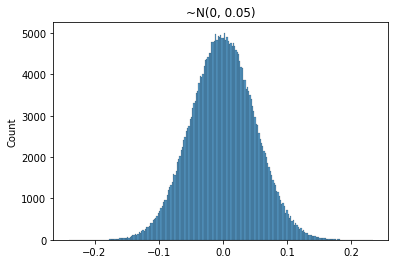

In [5]:
sns.histplot(data=np.random.normal(0, 0.05, 8000*39)).set_title("~N(0, 0.05)")

Text(0.5, 1.0, '~N(0, 0.1)')

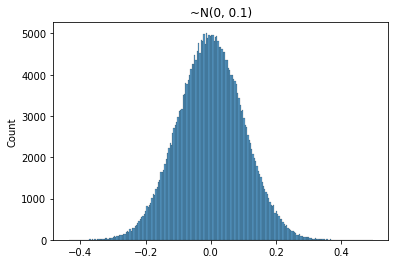

In [6]:
sns.histplot(data=np.random.normal(0, 0.1, 8000*39)).set_title("~N(0, 0.1)")

Text(0.5, 1.0, '~N(0, 0.15)')

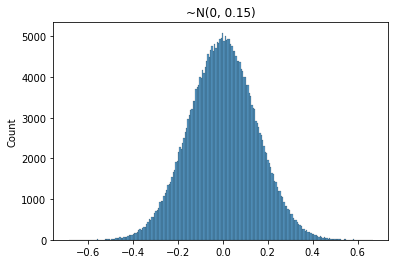

In [7]:
sns.histplot(data=np.random.normal(0, 0.15, 8000*39)).set_title("~N(0, 0.15)")

In [ ]:
def calc_last_quarters_returns_manual(fund, quarters):
    """
     this function calculates the last quarters returns. It iterates through all 
     rows. For each row it calculates the starting date and the ending date
     (+- 1 day to avoid minor numerical representation). Then it iterates over
     all rows between the following dates and uses acc variable to calculate return.
     The result is a series with same index as fund and it acc returns as values.
    """
    res_series = pd.Series(data=np.nan, index=fund.index)
    for row in fund.iteritems():
        end_time = row[0][1] + pd.Timedelta(days=1)
        start_time = pd.to_datetime(end_time) - pd.Series(data=[quarters]).map(pd.offsets.QuarterEnd)[0]
        start_time = max(mapping_dates.iloc[0], start_time) - pd.Timedelta(days=1)
        acc = 1
        for single_ts in fund.loc[(slice(row[0][0]), slice(start_time, end_time))].iteritems():
            curr_val = single_ts[1]
            acc = acc*(1 + (curr_val / 100))
        res_series[row[0]] = round((acc - 1)*100, 2)

    return res_series